In [ ]:
!pip install seaborn

In [ ]:
!pip show seaborn

In [2]:
import glob
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from collections import OrderedDict

class tasks:
    default = ["lambada", "piqa", "hellaswag", "winogrande", "mathqa", "pubmedqa"]
    ppl = ["wikitext", "pile_enron"]
    blimp_map = {
        "blimp_anaphor_gender_agreement": ("Anaphor agreement",),
        "blimp_anaphor_number_agreement": ("Anaphor agreement",),
        "blimp_animate_subject_passive": ("Argument structure",),
        "blimp_animate_subject_trans": ("Argument structure",),
        "blimp_causative": ("Argument structure",),
        "blimp_drop_argument": ("Argument structure",),
        "blimp_inchoative": ("Argument structure",),
        "blimp_intransitive": ("Argument structure",),
        "blimp_passive_1": ("Argument structure",),
        "blimp_passive_2": ("Argument structure",),
        "blimp_transitive": ("Argument structure",),
        "blimp_principle_A_c_command": ("Binding",),
        "blimp_principle_A_case_1": ("Binding",),
        "blimp_principle_A_case_2": ("Binding",),
        "blimp_principle_A_domain_1": ("Binding",),
        "blimp_principle_A_domain_2": ("Binding",),
        "blimp_principle_A_domain_3": ("Binding",),
        "blimp_principle_A_reconstruction": ("Binding",),
        "blimp_existential_there_object_raising": ("Control/raising",),
        "blimp_existential_there_subject_raising": ("Control/raising",),
        "blimp_expletive_it_object_raising": ("Control/raising",),
        "blimp_tough_vs_raising_1": ("Control/raising",),
        "blimp_tough_vs_raising_2": ("Control/raising",),
        "blimp_determiner_noun_agreement_1": ("Determiner-noun agr.",),
        "blimp_determiner_noun_agreement_2": ("Determiner-noun agr.",),
        "blimp_determiner_noun_agreement_irregular_1": ("Determiner-noun agr.",),
        "blimp_determiner_noun_agreement_irregular_2": ("Determiner-noun agr.",),
        "blimp_determiner_noun_agreement_with_adjective_1": ("Determiner-noun agr.",),
        "blimp_determiner_noun_agreement_with_adj_2": ("Determiner-noun agr.",),
        "blimp_determiner_noun_agreement_with_adj_irregular_1": ("Determiner-noun agr.",),
        "blimp_determiner_noun_agreement_with_adj_irregular_2": ("Determiner-noun agr.",),
        "blimp_ellipsis_n_bar_1": ("Ellipsis",),
        "blimp_ellipsis_n_bar_2": ("Ellipsis",),
        "blimp_wh_questions_object_gap": ("Filler gap",),
        "blimp_wh_questions_subject_gap": ("Filler gap",),
        "blimp_wh_questions_subject_gap_long_distance": ("Filler gap",),
        "blimp_wh_vs_that_no_gap": ("Filler gap",),
        "blimp_wh_vs_that_no_gap_long_distance": ("Filler gap",),
        "blimp_wh_vs_that_with_gap": ("Filler gap",),
        "blimp_wh_vs_that_with_gap_long_distance": ("Filler gap",),
        "blimp_irregular_past_participle_adjectives": ("Irregular forms",),
        "blimp_irregular_past_participle_verbs": ("Irregular forms",),
        "blimp_adjunct_island": ("Island effects",),
        "blimp_complex_NP_island": ("Island effects",),
        "blimp_coordinate_structure_constraint_complex_left_branch": ("Island effects",),
        "blimp_coordinate_structure_constraint_object_extraction": ("Island effects",),
        "blimp_left_branch_island_echo_question": ("Island effects",),
        "blimp_left_branch_island_simple_question": ("Island effects",),
        "blimp_sentential_subject_island": ("Island effects",),
        "blimp_wh_island": ("Island effects",),
        "blimp_matrix_question_npi_licensor_present": ("NPI licensing",),
        "blimp_npi_present_1": ("NPI licensing",),
        "blimp_npi_present_2": ("NPI licensing",),
        "blimp_only_npi_licensor_present": ("NPI licensing",),
        "blimp_only_npi_scope": ("NPI licensing",),
        "blimp_sentential_negation_npi_licensor_present": ("NPI licensing",),
        "blimp_sentential_negation_npi_scope": ("NPI licensing",),
        "blimp_existential_there_quantifiers_1": ("Quantifiers",),
        "blimp_existential_there_quantifiers_2": ("Quantifiers",),
        "blimp_superlative_quantifiers_1": ("Quantifiers",),
        "blimp_superlative_quantifiers_2": ("Quantifiers",),
        "blimp_distractor_agreement_relational_noun": ("Subject-verb agr.",),
        "blimp_distractor_agreement_relative_clause": ("Subject-verb agr.",),
        "blimp_irregular_plural_subject_verb_agreement_1": ("Subject-verb agr.",),
        "blimp_irregular_plural_subject_verb_agreement_2": ("Subject-verb agr.",),
        "blimp_regular_plural_subject_verb_agreement_1": ("Subject-verb agr.",),
        "blimp_regular_plural_subject_verb_agreement_2": ("Subject-verb agr.",),
    }
    blimp = list(blimp_map.keys())
    blimp_categories = [
        "Anaphor agreement",
        "Argument structure",
        "Binding",
        "Control/raising",
        "Determiner-noun agr.",
        "Ellipsis",
        "Filler gap",
        "Irregular forms",
        "Island effects",
        "NPI licensing",
        "Quantifiers",
        "Subject-verb agr.",
    ]
    
    @classmethod
    def get_categories(cls, task):
        if task in cls.blimp_map:
            return cls.blimp_map[task]
        return None

    @classmethod
    def get_default_metric(cls, task):
        if (task in cls.default) or (task in cls.blimp_map):
            return "acc"
        elif task in cls.ppl:
            return "bits_per_byte"
        return None
            
class models:
    all = ['dense_small', 'dense_medium', 'dense_large', '20B_placeholder']

class depth_methods:
    all = ["extra_linear", "final_linear", "logit_lens"]

class results_dir:
    rgx_toplevel = re.compile("^(.*)_eval_results_([0-9-]+).json$")
    rgx_plain = re.compile("^[^.]+$")
    rgx_step = re.compile("(^[^.]+)\.global_step(\d+)$")
    rgx_depth = re.compile("^([^.]+)\.([a-z_]*)\.(\d+)$")
    
    model_dtype = pd.CategoricalDtype(models.all, ordered=True)
    depth_method_dtype = pd.CategoricalDtype(depth_methods.all)
    
    def __init__(self, path):
        self.path = path
    
    @staticmethod
    def rchop(s, suffix):
        if suffix and s.endswith(suffix):
            return s[:-len(suffix)]
        return s

    @staticmethod
    def canonical_model_name(name):
        return results_dir.rchop(name, "_checkpoints")

    @classmethod
    def parse_results_file_name(cls, file_name):
        res = OrderedDict()
        m = cls.rgx_toplevel.match(file_name)
        if m is None:
            print("WARNING: cannot parse results file '{}'".format(file_name))
            return None

        run_id = m[1]
        res['path'] = file_name
        res['timestamp'] = m[2]

        m_step = cls.rgx_step.match(run_id)
        if m_step is not None:
            res['model'] = cls.canonical_model_name(m_step[1])
            res['experiment'] = "step"
            res['step'] = int(m_step[2])
            return res

        m_depth = cls.rgx_depth.match(run_id)
        if m_depth is not None:
            res['model'] = cls.canonical_model_name(m_depth[1])
            res['experiment'] = "layer"
            res['layer'] = int(m_depth[3])
            res['depth_method'] = m_depth[2]
            return res

        m_plain = cls.rgx_plain.match(run_id)
        if m_plain is not None:
            res['model'] = cls.canonical_model_name(m_plain[0])
            res['experiment'] = "model"
            return res

        print("WARNING: cannot parse run id '{}'".format(run_id))
        return None

    def as_df(self):
        dict_list = []
        for file_path in glob.glob(os.path.join(self.path, "*.json")):
            # Parse the file name and add
            meta = self.parse_results_file_name(os.path.basename(file_path))
            if meta is None:
                continue

            # Read the json file into a data frame

            with open(file_path) as f:
                try:
                    result_json = json.load(f)
                except:
                    print("WARNING: cannot load file '{}'".format(file_path))
                    continue

            records = []
            for task in result_json.keys():
                for metric in result_json[task]:
                    record = dict()
                    record["task"] = task
                    record["metric"] = metric
                    record["value"] = result_json[task][metric]
                    categories = tasks.get_categories(task)
                    
                    if categories is not None:
                        for i in range(len(categories)):
                            key = "category" if i == 0 else "grouping"
                            record[key] = categories[i]

                    meta_pos = 0
                    for meta_key in meta:
                        record[meta_key] = meta[meta_key]
                    dict_list.append(record)

        res = pd.json_normalize(dict_list)

        def set_col_type(col_name, t):
            if col_name in res:
                res[col_name] = res[col_name].astype(t)
        set_col_type('path', str)
        set_col_type('model', self.model_dtype)
        set_col_type('step', pd.Int64Dtype())
        set_col_type('layer', pd.Int64Dtype())
        set_col_type('depth_method', self.depth_method_dtype)
        set_col_type('task', str)
        set_col_type('metric', str)
        set_col_type('value', float)

        return res

class plot:
    @staticmethod
    def display_name(axis, value):
        if axis == "depth_method":
            if value == "extra_linear":
                return "tuned extra projection"
            if value == "final_linear":
                return "tuned unembedding"
            elif value == "logit_lens":
                return "logit lens"
        if axis == "model":
            return value.replace('_', ' ')
        return value

    @staticmethod
    def metric_display_name(metric):
        if metric == "acc":
            return "accuracy"
        if metric == "bits_per_byte":
            return "bits per byte"
        return metric

    @staticmethod
    def ensure_metric(metric, task_list):
        """Replace metric with default if the metric is None"""
        if metric is None:
            if type(task_list) is not list:
                task_list = [task_list]

            for task in task_list:
                m = tasks.get_default_metric(task)
                if (metric is not None) and (metric != m):
                    raise Exception("Tasks have incompatible default metrics {}, {}.".format(metric, m))
                metric = m
        return metric


    @staticmethod
    def data_by_axis(df, metric, x_axis, axes):
        axes_flat = []
        for key in axes.keys():
            if axes[key] is not None:
                axes_flat.append((key, axes[key]))
        display_metric = plot.metric_display_name(metric)
        
        expr = df[x_axis].notnull() & (df["metric"] == metric)
        lists = 0
        hue = None
        title = None
        
        for axis, constraint in axes_flat:
            if type(constraint) is not list:
                expr = expr & (df[axis] == constraint)
                
                constraint_display = plot.display_name(axis, constraint)
                if title is None:
                    title = constraint_display
                else:
                    title = title + ", " + constraint_display
            else:
                expr = expr & (df[axis].isin(constraint))
                hue = axis
                lists = lists + 1
        if lists > 1:
            raise ValueError("At most one of the axes can be a list")

        df = df[expr].rename(columns={"value": display_metric})
        return df, title, display_metric, hue

    @staticmethod
    def by_axis(df, x_axis, metric=None, **axes):
        metric = plot.ensure_metric(metric, axes["task"])
        
        df, title, display_metric, hue = plot.data_by_axis(df, metric, x_axis, axes)
        p = sns.lineplot(data=df, x=x_axis, y=display_metric, hue=hue, style=hue, marker='o')
        p.set_title(title)
        return p

    @staticmethod
    def by_step(df, model, task, metric=None, category=None):
        return plot.by_axis(df, x_axis="step", model=model, metric=metric, task=task, category=category)

    @staticmethod
    def by_layer(df, model, task, depth_method="extra_linear", metric=None, category=None):
        return plot.by_axis(df, x_axis="layer", model=model, metric=metric, task=task, depth_method=depth_method, category=category)

    @staticmethod
    def by_model(df, task, metric=None):
        metric = plot.ensure_metric(metric, task)
        display_metric = plot.metric_display_name(metric)
        if type(task) is not list:
            task = [task]

        df = df[(df["step"].isnull() & df["layer"].isnull() & df["task"].isin(task)) & (df["metric"] == metric)]
        df = df.rename(columns={"value": display_metric})
        return sns.lineplot(data=df, x="model", y=display_metric, hue="task", marker='o')
    
    @staticmethod
    def by3(df, model, task, metric=None, category=None):
        f = plt.figure(figsize=(21, 6))
        gs = f.add_gridspec(1, 3)

        # Create the by-layer plot
        ax1 = f.add_subplot(gs[0, 0])
        p = plot.by_layer(df, metric=metric, model=model, task=task, category=category)
        p.get_legend().remove() if p.get_legend() else None

        # Create the by-step plot
        ax2 = f.add_subplot(gs[0, 1])
        p = plot.by_step(df, metric=metric, model=model, task=task, category=category)
        p.get_legend().remove() if p.get_legend() else None
        p.set(ylabel=None)

        # Create the by-model plot
        ax3 = f.add_subplot(gs[0, 2])
        p = plot.by_model(df, metric=metric, task=task)
        p.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        p.set(ylabel=None)

        # Align the plots along the y-axis
        axs = [ax1, ax2, ax3]
        y_min = min([ax.get_ylim()[0] for ax in axs])
        y_max = max([ax.get_ylim()[1] for ax in axs])
        for ax in axs:
            ax.set_ylim(y_min, y_max)

        f.show()
        return f

    @staticmethod
    def multi(df, primary_axis, **args):
        col_num = 3
        plot_dim = (7, 5)
        primary_vals = args[primary_axis]
        row_num = (len(primary_vals) + (col_num - 1)) // col_num
        f = plt.figure(figsize=(plot_dim[0] * col_num, plot_dim[1] * row_num))

        gs = f.add_gridspec(row_num, col_num)

        for i in range(len(primary_vals)):
            primary_val = primary_vals[i]
            cur_args = args
            cur_args[primary_axis] = primary_val
            ax = f.add_subplot(gs[i // col_num, i % col_num])
            plot.by_axis(df, **args)

In [3]:
df = results_dir("/mnt/ssd-1/igor/gpt-neox/results").as_df()

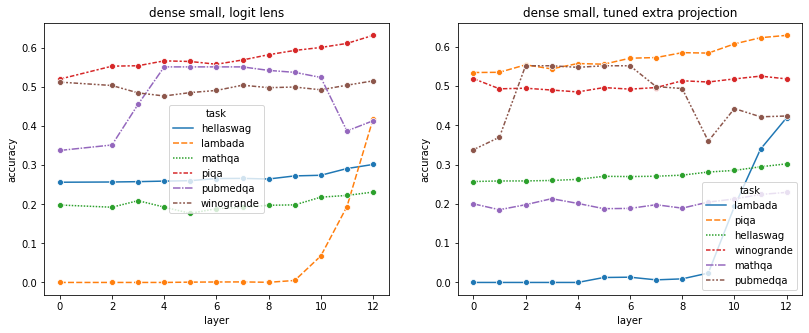

In [4]:
plot.multi(df, primary_axis="depth_method", x_axis="layer", model="dense_small", depth_method=["logit_lens", "extra_linear"], task=tasks.default)

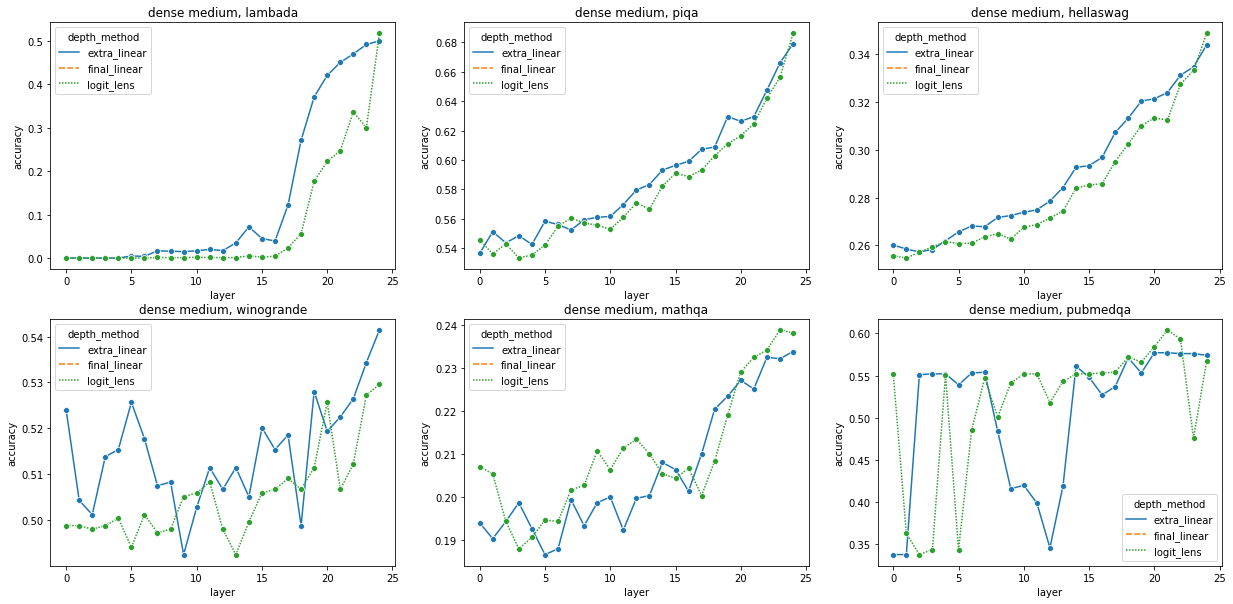

In [5]:
plot.multi(df, primary_axis="task", x_axis="layer", model="dense_medium", depth_method=["logit_lens", "extra_linear"], task=tasks.default)

In [8]:
# Optionally pickle the results
import time
if True:
    import dill
    timestr = time.strftime("%Y%m%d-%H%M%S")
    #pickle_path = "/home/mchorse/igor/igor0.github.io/experiments/pythia/results.{}.pickle".format(timestr)
    pickle_path = "/home/mchorse/igor/results.pickle"
    with open(pickle_path, "wb") as fh:
        dill.dump((df, tasks, plot, models, depth_methods), fh)
        #pickle.dump(df, fh)

In [ ]:
with open("/home/mchorse/igor/igor0.github.io/experiments/pythia/results.pickle", "rb") as fh:
    x1, x2, x3, x4 = pickle.load(fh)

In [ ]:
sns.set_style("darkgrid")

In [ ]:
p = plot.by3(df, model="dense_medium", task=tasks.ppl)

In [ ]:
plot.multi(df, primary_axis="task", x_axis="layer", metric="bits_per_byte", model="dense_small", depth_method=["logit_lens", "extra_linear"], task=tasks.ppl)

In [ ]:
p = plot.by3(df, model="dense_large", task=tasks.default)

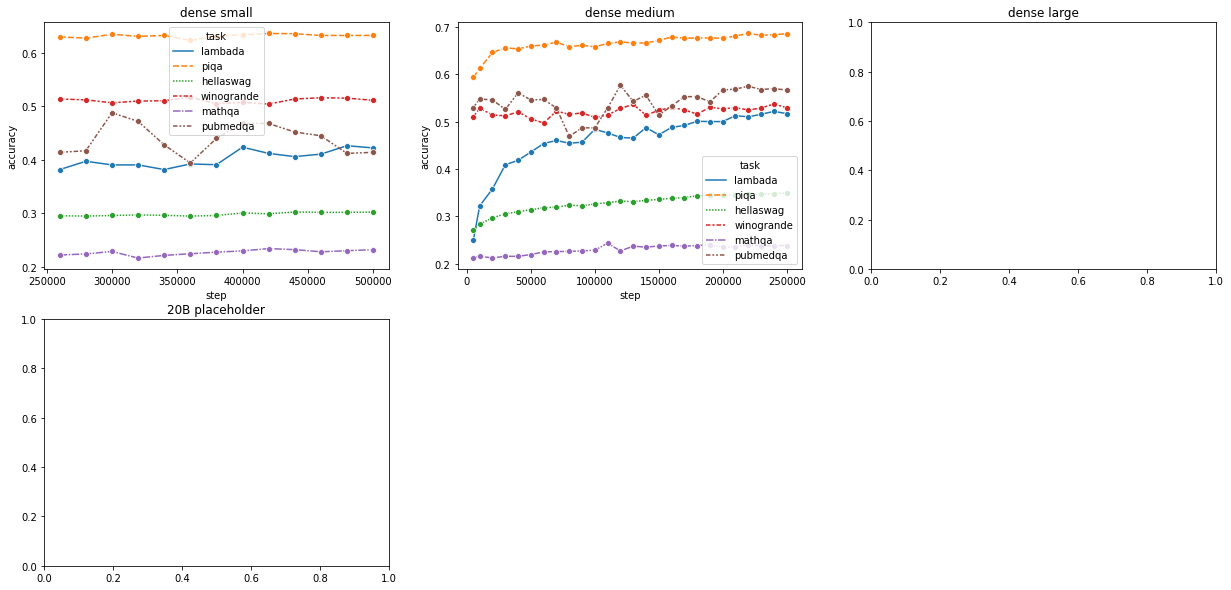

In [7]:
plot.multi(df, primary_axis="model", x_axis="step", model=models.all, task=tasks.default)